# This notebook plots distribution of grid point level rain rates and rain amounts

In [16]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
%matplotlib inline

In [17]:
# Dictionary for official model names
model_name = {
    'obs': 'OBS',
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

# Select a region (Tropics, MC, WP, IO, AFC, AMZ)
region = 'tropics'

test = ''
# test = '_ccs1_2h'
rootdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/'
obsdir = f'{rootdir}obs/stats{test}/'
obsfile = f'{obsdir}mcs_rainrate_hist_20200201_20200228_{region}.nc'

name_map = {
    'obs': 'obs',
    'm1': 'mpi',
    'm2': 'scream',
    'm3': 'nasa',
    'm4': 'nicam',
    'm5': 'noaa',
    'm6': 'uk',
}
m1dir = f'{rootdir}{name_map["m1"]}/stats{test}/'
m2dir = f'{rootdir}{name_map["m2"]}/stats{test}/'
m3dir = f'{rootdir}{name_map["m3"]}/stats{test}/'
m4dir = f'{rootdir}{name_map["m4"]}/stats{test}/'
m5dir = f'{rootdir}{name_map["m5"]}/stats{test}/'
m6dir = f'{rootdir}{name_map["m6"]}/stats{test}/'
m1file = f'{m1dir}mcs_rainrate_hist_20200201_20200228_{region}.nc'
m2file = f'{m2dir}mcs_rainrate_hist_20200201_20200228_{region}.nc'
m3file = f'{m3dir}mcs_rainrate_hist_20200201_20200228_{region}.nc'
m4file = f'{m4dir}mcs_rainrate_hist_20200201_20200228_{region}.nc'
m5file = f'{m5dir}mcs_rainrate_hist_20200201_20200228_{region}.nc'
m6file = f'{m6dir}mcs_rainrate_hist_20200201_20200228_{region}.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/


In [18]:
obsfile, m1file, m2file, m3file, m4file, m5file, m6file

('/global/cfs/cdirs/m1867/zfeng/dyamond-winter/obs/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/mpi/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/scream/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nasa/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nicam/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/noaa/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/uk/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc')

In [19]:
name_map.keys()

dict_keys(['obs', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6'])

In [20]:
datafiles = [obsfile, m1file, m2file, m3file, m4file, m5file, m6file]
# Read all data in Xarray Dataset
ds = xr.open_mfdataset(datafiles, concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
ds['source'] = ['obs', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6']
rrbins = ds.bins
lon_bounds = ds.attrs['lonbox']
lat_bounds = ds.attrs['latbox']
ds

<xarray.Dataset>
Dimensions:          (source: 7, bins: 199)
Coordinates:
  * bins             (bins) int64 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * source           (source) <U3 'obs' 'm1' 'm2' 'm3' 'm4' 'm5' 'm6'
Data variables:
    total_land       (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_land         (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_land         (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_land   (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    total_ocean      (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_ocean        (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_ocean        (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_ocean  (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
Attributes:
    title:       Precipitation PDF by types
    lonbox:      [  0. 360.]
    latbox:      [-20.  15.]
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Feb 16 13:05:59 2022

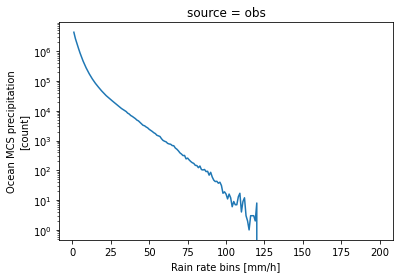

In [21]:
ds.sel(source='obs').mcs_ocean.plot()
plt.yscale('log')

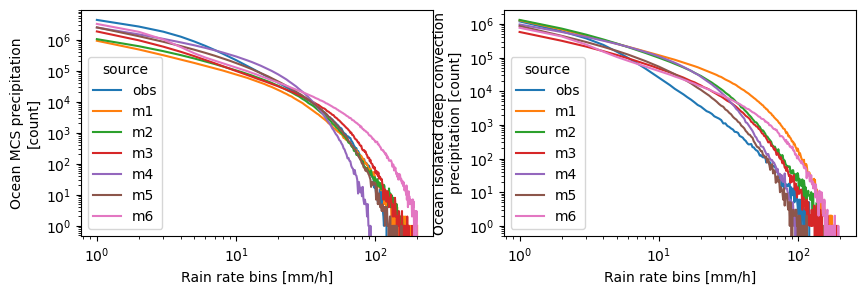

In [22]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(ds.mcs_ocean, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(ds.idc_ocean, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

## Normalize histogram by dividing the sum over all bins

In [23]:
norm_mcs_o = ds.mcs_ocean / ds.mcs_ocean.sum(dim='bins')
norm_idc_o = ds.idc_ocean / ds.idc_ocean.sum(dim='bins')

norm_mcs_l = ds.mcs_land / ds.mcs_land.sum(dim='bins')
norm_idc_l = ds.idc_land / ds.idc_land.sum(dim='bins')

## Calculate histogram of rain amount by rain rate

In [24]:
mcsamt_hist_o = ds.mcs_ocean * rrbins
idcamt_hist_o = ds.idc_ocean * rrbins

mcsamt_hist_l = ds.mcs_land * rrbins
idcamt_hist_l = ds.idc_land * rrbins

In [67]:
totamt_hist_o = ds.total_ocean * rrbins
totamt_hist_l = ds.total_land * rrbins

totamt_cumhist_o = totamt_hist_o.cumsum(dim='bins')
totamt_cumhist_l = totamt_hist_l.cumsum(dim='bins')

No handles with labels found to put in legend.


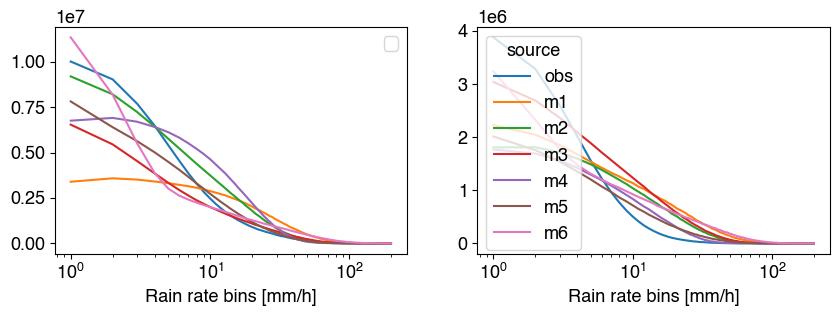

In [66]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(totamt_hist_o, x='bins', ax=ax0)
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.legend(loc='upper right')
ax1 = axes[1]
xr.plot.line(totamt_hist_l, x='bins', ax=ax1)
# ax1.set_yscale('log')
ax1.set_xscale('log')

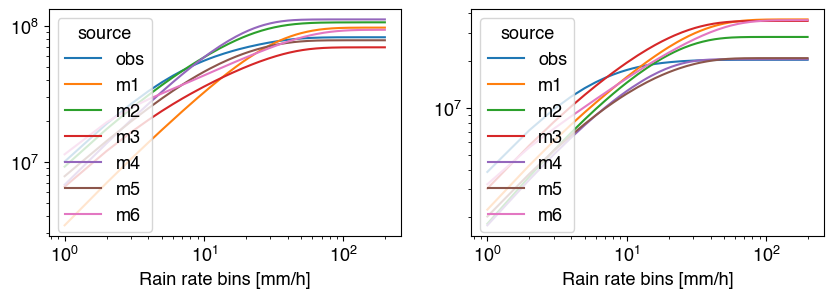

In [68]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(totamt_cumhist_o, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
# ax0.legend(loc='upper right')
ax1 = axes[1]
xr.plot.line(totamt_cumhist_l, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

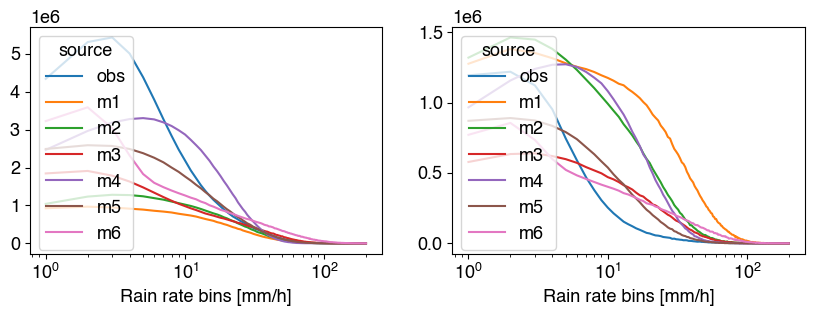

In [46]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_hist_o, x='bins', ax=ax0)
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_hist_o, x='bins', ax=ax1)
# ax1.set_yscale('log')
ax1.set_xscale('log')

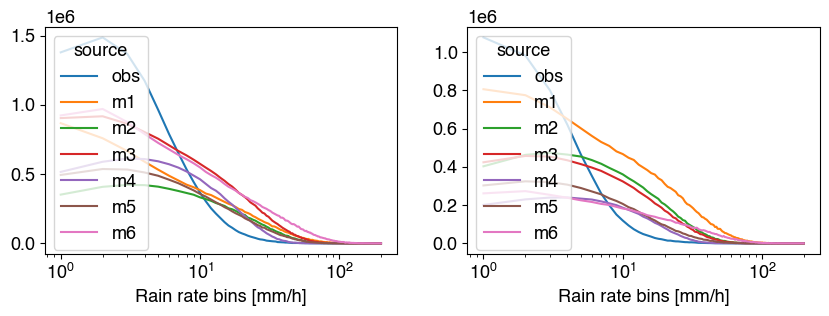

In [47]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_hist_l, x='bins', ax=ax0)
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_hist_l, x='bins', ax=ax1)
# ax1.set_yscale('log')
ax1.set_xscale('log')

## Calculate cumulative histogram of rain amount by rain rate

In [27]:
# Ocean
mcsamt_cumhist_o = (ds.mcs_ocean * rrbins).cumsum(dim='bins')
idcamt_cumhist_o = (ds.idc_ocean * rrbins).cumsum(dim='bins') 
# # Normalized by total rain amount for each type
# norm_mcsamt_cumhist_o = mcsamt_cumhist_o / (ds.mcs_ocean * rrbins).sum(dim='bins')
# norm_idcamt_cumhist_o = idcamt_cumhist_o / (ds.idc_ocean * rrbins).sum(dim='bins')

# Land
mcsamt_cumhist_l = (ds.mcs_land * rrbins).cumsum(dim='bins')
idcamt_cumhist_l = (ds.idc_land * rrbins).cumsum(dim='bins') 
# # Normalized by total rain amount for each type
# norm_mcsamt_cumhist_l = mcsamt_cumhist_l / (ds.mcs_land * rrbins).sum(dim='bins')
# norm_idcamt_cumhist_l = idcamt_cumhist_l / (ds.idc_land * rrbins).sum(dim='bins')

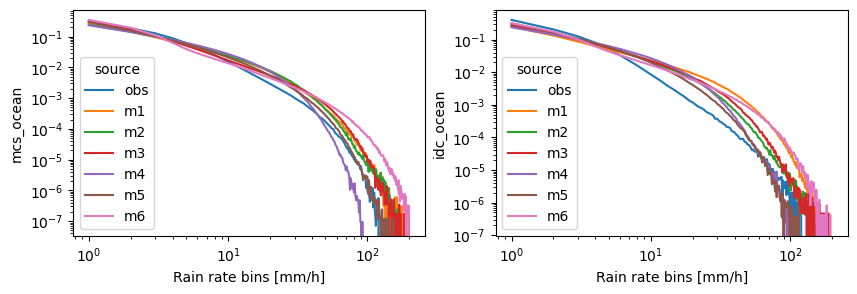

In [28]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(norm_mcs_o, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(norm_idc_o, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

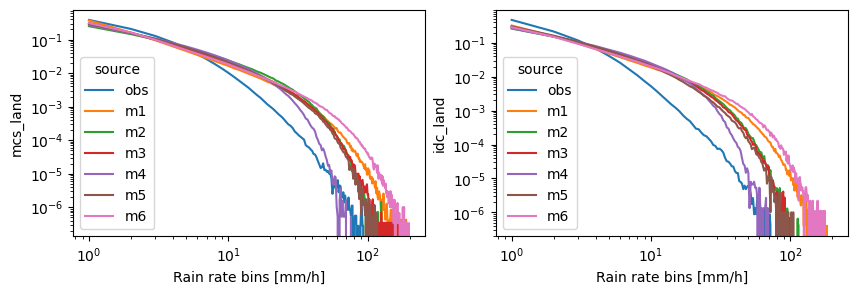

In [29]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(norm_mcs_l, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(norm_idc_l, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

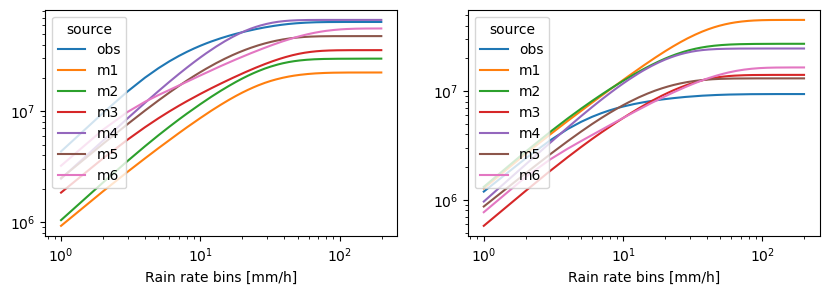

In [30]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_cumhist_o, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_cumhist_o, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

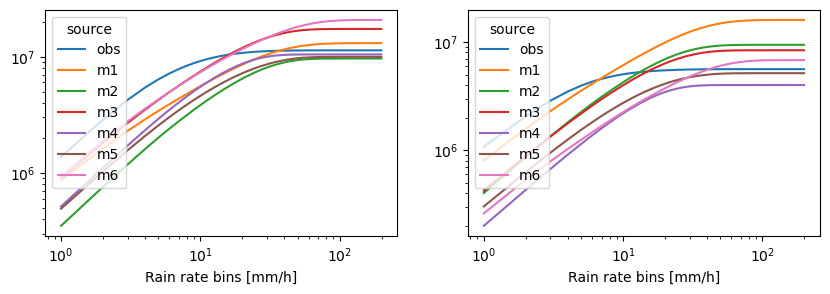

In [31]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_cumhist_l, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_cumhist_l, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

In [32]:
legends = {
    'obs': model_name[name_map['obs']],
    'm1': model_name[name_map['m1']],
    'm2': model_name[name_map['m2']],
    'm3': model_name[name_map['m3']],
    'm4': model_name[name_map['m4']],
    'm5': model_name[name_map['m5']],
    'm6': model_name[name_map['m6']],
}
map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
map_extent, lonbox, latbox

([0.0, 359.0, -40.0, 35.0], [0.0, 359.0], [-20.0, 15.0])

## Function to plot mirror PDF

In [55]:
def plot_pdf_mirror_mxn(nrow, ncol, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                xscale=None, yscale=None, xlims=None, ylims=None, label_topbot=None, label_pos=None,
                legend_fontsize=11, legend_loc=None, legend_ncol=None, figsize=[10,10]):
    
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.15, hspace=0.25)
    # Use GridSpecFromSubplotSpec to setup top and bottom mirror panels
    gs_top = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], height_ratios=[0.5,0.5], width_ratios=[1,1,], wspace=0.18, hspace=0)
    gs_bot = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], height_ratios=[0.5,0.5], width_ratios=[1,1,], wspace=0.18, hspace=0)
    
    lw = 2
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'blue',
        'm6': 'purple',
    }
    
    # Top row
    row = 0
    for col in range(0, ncol):
        # Top panel
        ax1 = plt.subplot(gs_top[0,col])
        ax1.plot(bins, data_top[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
        ax1.plot(bins, data_top[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
        ax1.plot(bins, data_top[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
        ax1.plot(bins, data_top[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
        ax1.plot(bins, data_top[row][col].sel(source='m4'), lcolors['m4'], lw=lw, label=legends['m4'])
        ax1.plot(bins, data_top[row][col].sel(source='m5'), lcolors['m5'], lw=lw, label=legends['m5'])
        ax1.plot(bins, data_top[row][col].sel(source='m6'), lcolors['m6'], lw=lw, label=legends['m6'])
        # Bottom panel
        ax2 = plt.subplot(gs_top[1,col], sharex=ax1, sharey=ax1)
        # ax2.invert_yaxis()
        ax2.plot(bins, data_bot[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
        ax2.plot(bins, data_bot[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
        ax2.plot(bins, data_bot[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
        ax2.plot(bins, data_bot[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
        ax2.plot(bins, data_bot[row][col].sel(source='m4'), lcolors['m4'], lw=lw, label=legends['m4'])
        ax2.plot(bins, data_bot[row][col].sel(source='m5'), lcolors['m5'], lw=lw, label=legends['m5'])
        ax2.plot(bins, data_bot[row][col].sel(source='m6'), lcolors['m6'], lw=lw, label=legends['m6'])
        # Labels, gridlines, etc.
        ax1.grid(which='major', ls='--')
        ax2.grid(which='major', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels)
        # Label top/bottom panels
        ax1.text(label_pos['top']['x'], label_pos['top']['y'], label_topbot['top'], ha='left', transform=ax1.transAxes)
        ax2.text(label_pos['top']['x'], label_pos['top']['y'], label_topbot['bottom'], ha='left', transform=ax2.transAxes)
        # Label yaxis, legend
        if (col == 0):
            ax1.legend(fontsize=legend_fontsize, loc=legend_loc[0], ncol=legend_ncol[0])
            ax1.text(-0.15, 1, ylabels[row][col], va='center', ha='center', rotation=90, transform=ax2.transAxes)
        ax1.set_yscale(yscale[row])
        ax1.set_xscale(xscale)
        ax1.tick_params(labelbottom=False)
        ax1.set_xlim(xlims[0], xlims[1])
        ax1.set_ylim(ylims[row][col][0], ylims[row][col][1])
        
        # Plot inset map
        if (row == 0):
            resolution = '110m'
            land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
            ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
            proj = ccrs.PlateCarree(central_longitude=180)
            box_proj = ccrs.PlateCarree(central_longitude=0)
            sub_ax = inset_axes(ax1, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                axes_kwargs=dict(map_projection=proj))
            sub_ax.set_extent(map_extent, box_proj)
            # Add land, coastlines, borders to inset
            sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
            sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
            # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
            sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
            # Plot a box region in the inset
            box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
            sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
            sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    # Bottom row
    row = 1
    for col in range(0, ncol): 
        # Top panel
        ax1 = plt.subplot(gs_bot[0,col])
        ax1.plot(bins, data_top[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
        ax1.plot(bins, data_top[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
        ax1.plot(bins, data_top[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
        ax1.plot(bins, data_top[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
        ax1.plot(bins, data_top[row][col].sel(source='m4'), lcolors['m4'], lw=lw, label=legends['m4'])
        ax1.plot(bins, data_top[row][col].sel(source='m5'), lcolors['m5'], lw=lw, label=legends['m5'])
        ax1.plot(bins, data_top[row][col].sel(source='m6'), lcolors['m6'], lw=lw, label=legends['m6'])
        # Bottom panel
        ax2 = plt.subplot(gs_bot[1,col], sharex=ax1, sharey=ax1)
        ax2.plot(bins, data_bot[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
        ax2.plot(bins, data_bot[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
        ax2.plot(bins, data_bot[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
        ax2.plot(bins, data_bot[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
        ax2.plot(bins, data_bot[row][col].sel(source='m4'), lcolors['m4'], lw=lw, label=legends['m4'])
        ax2.plot(bins, data_bot[row][col].sel(source='m5'), lcolors['m5'], lw=lw, label=legends['m5'])
        ax2.plot(bins, data_bot[row][col].sel(source='m6'), lcolors['m6'], lw=lw, label=legends['m6'])
        # Labels, gridlines, etc.
        ax1.grid(which='major', ls='--')
        ax2.grid(which='major', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels)
        # Label top/bottom panels
        ax1.text(label_pos['bottom']['x'], label_pos['bottom']['y'], label_topbot['top'], ha='left', transform=ax1.transAxes)
        ax2.text(label_pos['bottom']['x'], label_pos['bottom']['y'], label_topbot['bottom'], ha='left', transform=ax2.transAxes)
        # Label yaxis, legend
        if (col == 0):
            ax1.legend(fontsize=legend_fontsize, loc=legend_loc[1], ncol=legend_ncol[1])
            ax1.text(-0.15, 1, ylabels[row][col], va='center', ha='center', rotation=90, transform=ax2.transAxes)
        ax1.set_yscale(yscale[row])
        ax1.set_xscale(xscale)
        ax1.tick_params(labelbottom=False)
        ax1.set_xlim(xlims[0], xlims[1])
        ax1.set_ylim(ylims[row][col][0], ylims[row][col][1])
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

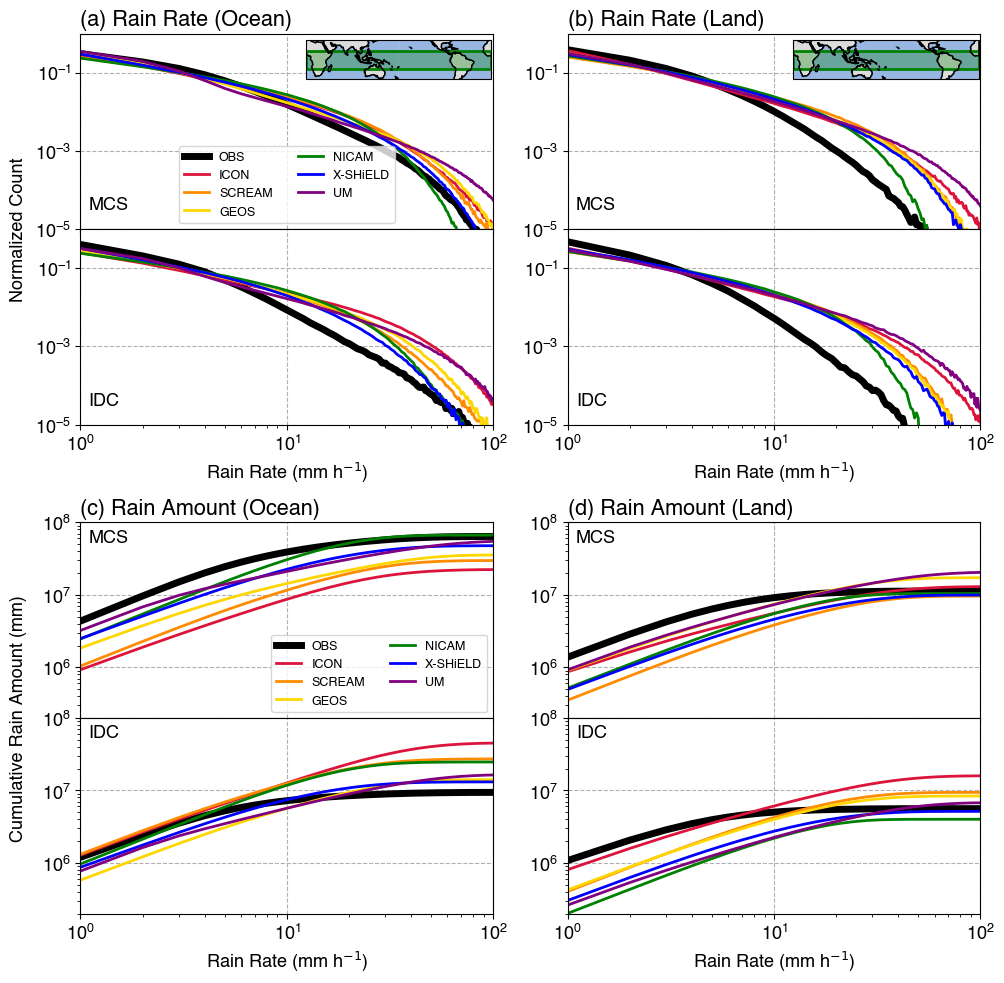

In [81]:
bins = rrbins
data_top = [
    [norm_mcs_o, norm_mcs_l,], 
    [mcsamt_cumhist_o, mcsamt_cumhist_l,],
]
data_bot = [
    [norm_idc_o, norm_idc_l,], 
    [idcamt_cumhist_o, idcamt_cumhist_l,],
]
titles = [
    ['(a) Rain Rate (Ocean)', '(b) Rain Rate (Land)', ],
    ['(c) Rain Amount (Ocean)', '(d) Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', 'Normalized Count'],
    ['Cumulative Rain Amount (mm)', 'Cumulative Rain Amount (mm)'],
]
label_topbot = {'top':'MCS', 'bottom':'IDC'}
label_pos = {'top':{'x':0.02, 'y':0.1}, 'bottom':{'x':0.02, 'y':0.9}}
legend_loc = ['lower center', 'lower right']
legend_ncol = [2, 2]
xscale = 'log'
yscale = ['log','log']
xlims = [1, 100]
ylims = [
    [[1e-5,1], [1e-5,1]],
    [[2e5,1e8], [2e5,1e8]],
]
inset_param = {'width':'45%', 'height':'25%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamountcumulative_pdf_mcs_idc_{region}.png'
fig = plot_pdf_mirror_mxn(2, 2, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims, label_topbot=label_topbot, label_pos=label_pos,
                   legend_fontsize=9, legend_loc=legend_loc, legend_ncol=legend_ncol, figsize=[10,11])

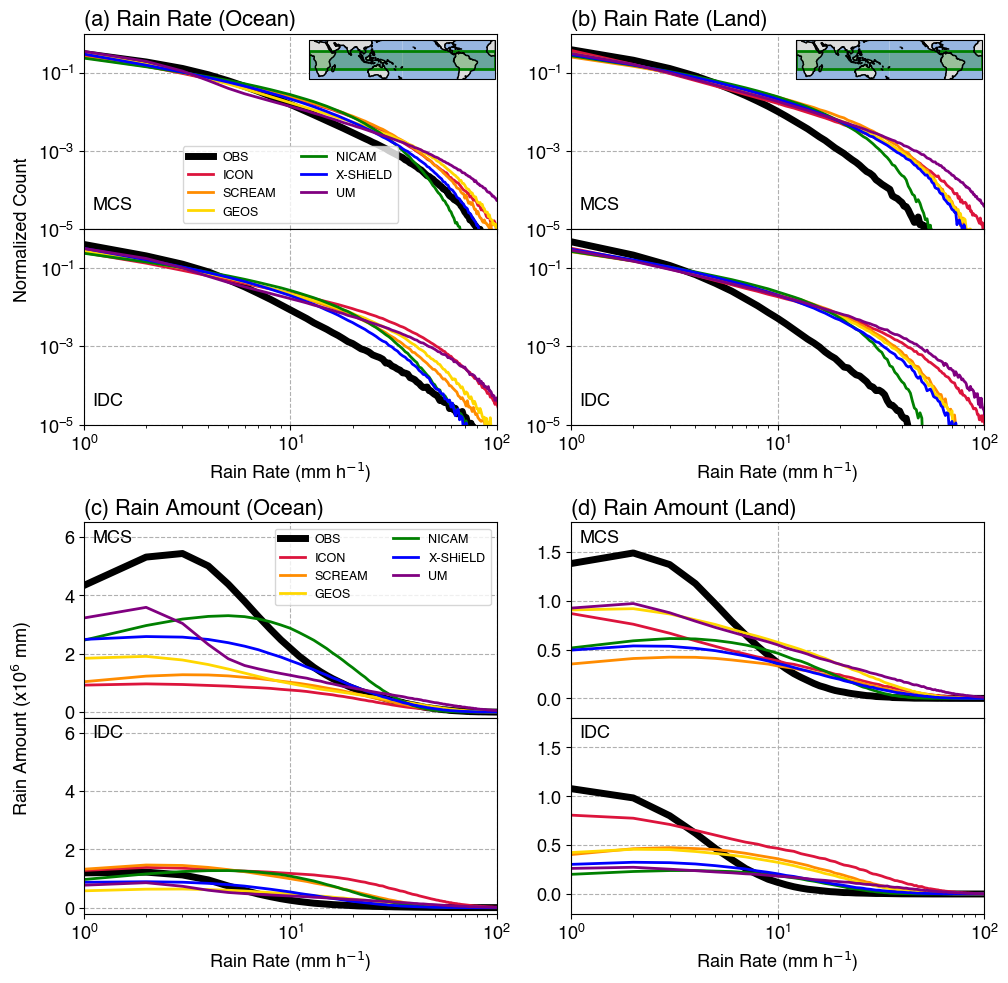

In [82]:
bins = rrbins
amt_scale_factor = 6
amt_scale = 10**amt_scale_factor
data_top = [
    [norm_mcs_o, norm_mcs_l,], 
    [mcsamt_hist_o/amt_scale, mcsamt_hist_l/amt_scale,],
]
data_bot = [
    [norm_idc_o, norm_idc_l,], 
    [idcamt_hist_o/amt_scale, idcamt_hist_l/amt_scale,],
]
titles = [
    ['(a) Rain Rate (Ocean)', '(b) Rain Rate (Land)', ],
    ['(c) Rain Amount (Ocean)', '(d) Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', 'Normalized Count'],
    [f'Rain Amount (x10$^{amt_scale_factor}$ mm)', f'Rain Amount (x10$^{amt_scale_factor}$ mm)'],
]
label_topbot = {'top':'MCS', 'bottom':'IDC'}
label_pos = {'top':{'x':0.02, 'y':0.1}, 'bottom':{'x':0.02, 'y':0.9}}
legend_loc = ['lower center', 'upper right']
legend_ncol = [2, 2]
xscale = 'log'
yscale = ['log','linear']
xlims = [1, 100]
ylims = [
    [[1e-5,1], [1e-5,1]],
    [[-0.2,6.5], [-0.2,1.8]],
]
inset_param = {'width':'45%', 'height':'25%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_mcs_idc_{region}.png'
fig = plot_pdf_mirror_mxn(2, 2, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims, label_topbot=label_topbot, label_pos=label_pos,
                   legend_fontsize=9, legend_loc=legend_loc, legend_ncol=legend_ncol, figsize=[10,11])

In [58]:
figname

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/rainrate_rainamount_pdf_mcs_idc_tropics.png'

In [75]:
def plot_pdf_mxn(nrow, ncol, bins, data_arr, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                xscale=None, yscale=None, xlims=None, ylims=None,
                legend_fontsize=11, legend_loc='best', figsize=[10,10]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)

    lw = 2
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'blue',
        'm6': 'purple',
    }

    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = axes[row][col]           
            ax.plot(bins, data_arr[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
            ax.plot(bins, data_arr[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
            ax.plot(bins, data_arr[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
            ax.plot(bins, data_arr[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
            ax.plot(bins, data_arr[row][col].sel(source='m4'), lcolors['m4'], lw=lw, label=legends['m4'])
            ax.plot(bins, data_arr[row][col].sel(source='m5'), lcolors['m5'], lw=lw, label=legends['m5'])
            ax.plot(bins, data_arr[row][col].sel(source='m6'), lcolors['m6'], lw=lw, label=legends['m6'])
            # Labels
            # if (row == 0): 
            ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='right')
            ax.set_xlabel(xlabels)
            ax.set_ylabel(ylabels[row][col])
            ax.set_yscale(yscale[row])
            ax.set_xscale(xscale)
            # ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[row][col][0], ylims[row][col][1])
            
            # Plot inset map
            if (row == map_panel[0]) & (col == map_panel[1]):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                # borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.8, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

<ipython-input-75-39c35ebbdd5b>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


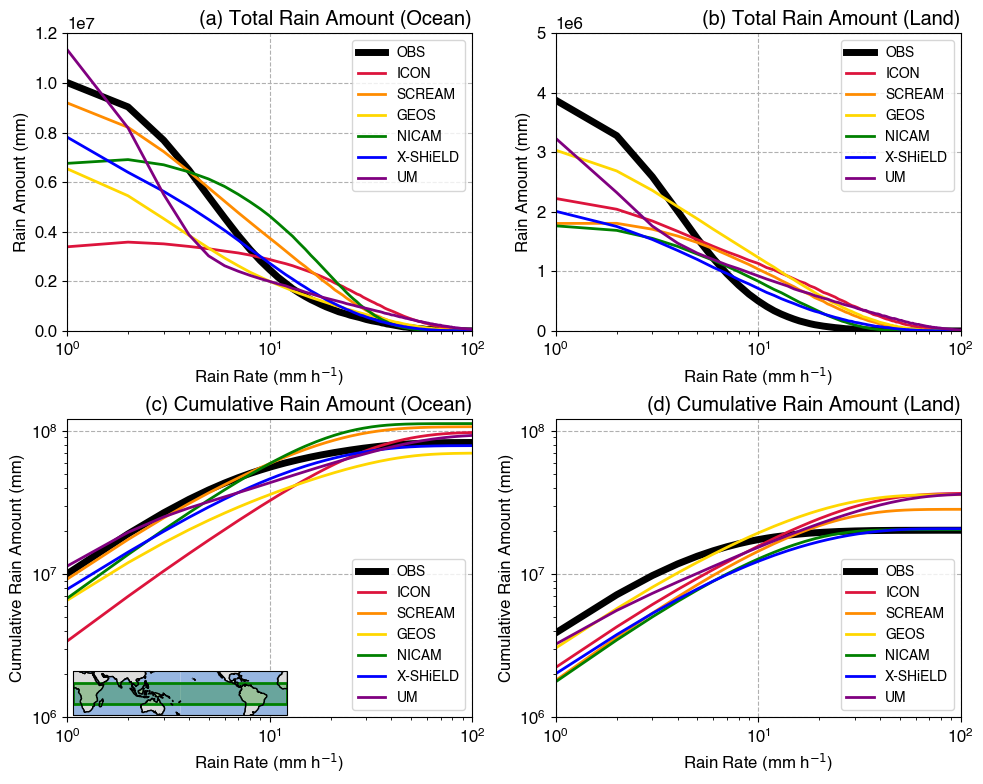

In [80]:
# amt_scale_factor = 6
# amt_scale = 10**amt_scale_factor

bins = rrbins
data_arr = [
    [totamt_hist_o, totamt_hist_l,], 
    [totamt_cumhist_o, totamt_cumhist_l,],
]
titles = [
    ['(a) Total Rain Amount (Ocean)', '(b) Total Rain Amount (Land)', ],
    ['(c) Cumulative Rain Amount (Ocean)', '(d) Cumulative Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Rain Amount (mm)', 'Rain Amount (mm)'],
    ['Cumulative Rain Amount (mm)', 'Cumulative Rain Amount (mm)'],
]
xscale = 'log'
yscale = ['linear','log']
xlims = [1, 100]
ylims = [
    [[0,1.2e7], [0,0.5e7]],
    [[1e6,1.2e8], [1e6,1.2e8]],
]
inset_param = {'width':'55%', 'height':'15%', 'loc':'lower left', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_total_{region}.png'
fig = plot_pdf_mxn(2, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[1,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims,
                   legend_fontsize=10, legend_loc='best', figsize=[10,8])

<ipython-input-18-3596e831e6d4>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


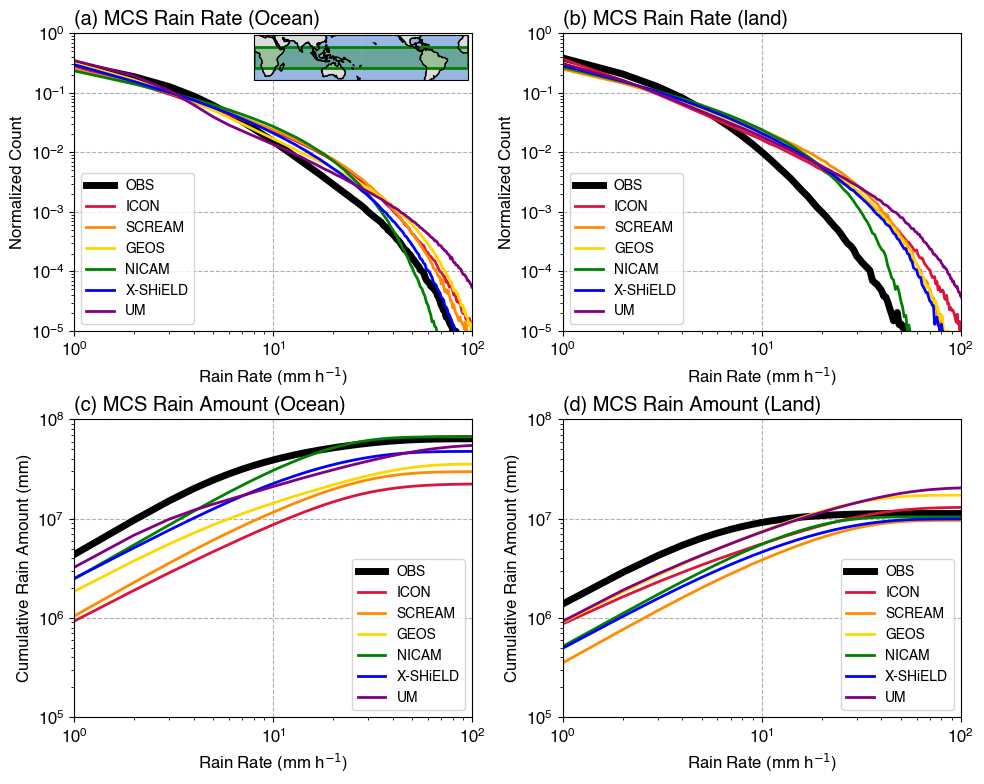

In [19]:
bins = rrbins
data_arr = [
    [norm_mcs_o, norm_mcs_l,], 
    [mcsamt_cumhist_o, mcsamt_cumhist_l,],
]
titles = [
    ['(a) MCS Rain Rate (Ocean)', '(b) MCS Rain Rate (land)', ],
    ['(c) MCS Rain Amount (Ocean)', '(d) MCS Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', 'Normalized Count'],
    ['Cumulative Rain Amount (mm)', 'Cumulative Rain Amount (mm)'],
]
xscale = 'log'
yscale = 'log'
xlims = [1, 100]
ylims = [
    [[1e-5,1], [1e-5,1]],
    [[1e5,1e8], [1e5,1e8]],
]
inset_param = {'width':'55%', 'height':'15%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_mcs_{region}.png'
fig = plot_pdf_mxn(2, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims,
                   legend_fontsize=10, legend_loc='best', figsize=[10,8])

<ipython-input-18-3596e831e6d4>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


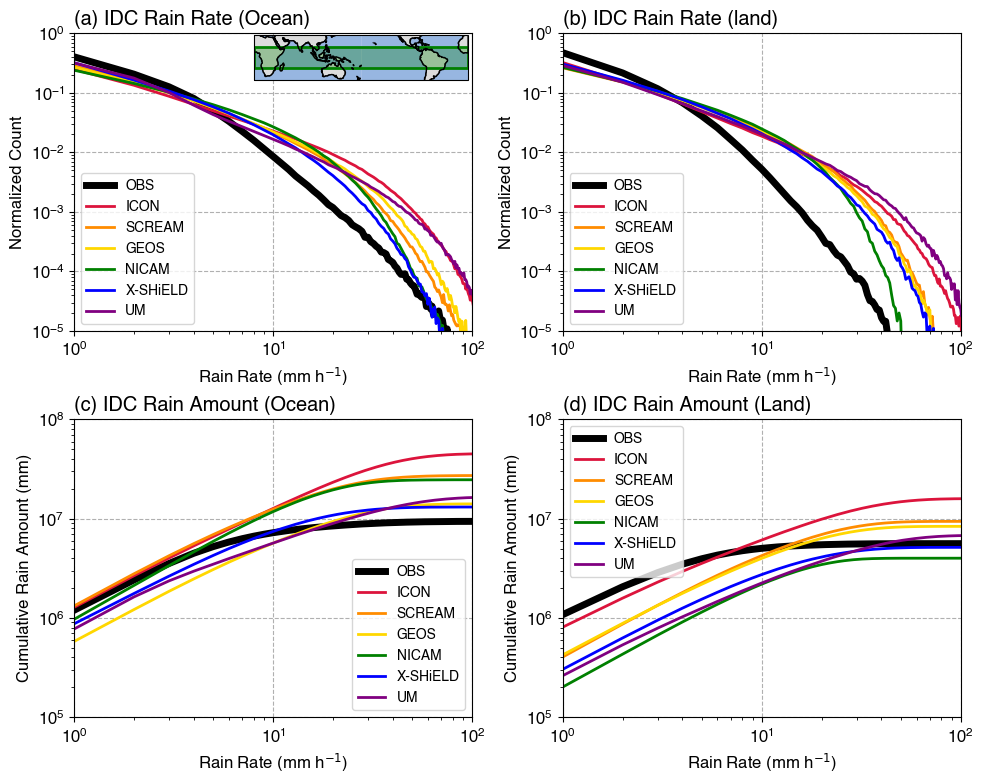

In [20]:
bins = rrbins
data_arr = [
    [norm_idc_o, norm_idc_l,], 
    [idcamt_cumhist_o, idcamt_cumhist_l,],
]
titles = [
    ['(a) IDC Rain Rate (Ocean)', '(b) IDC Rain Rate (land)', ],
    ['(c) IDC Rain Amount (Ocean)', '(d) IDC Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', 'Normalized Count'],
    ['Cumulative Rain Amount (mm)', 'Cumulative Rain Amount (mm)'],
]
xscale = 'log'
yscale = 'log'
xlims = [1, 100]
ylims = [
    [[1e-5,1], [1e-5,1]],
    [[1e5,1e8], [1e5,1e8]],
]
inset_param = {'width':'55%', 'height':'15%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_idc_{region}.png'
fig = plot_pdf_mxn(2, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims,
                   legend_fontsize=10, legend_loc='best', figsize=[10,8])

<ipython-input-18-3596e831e6d4>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


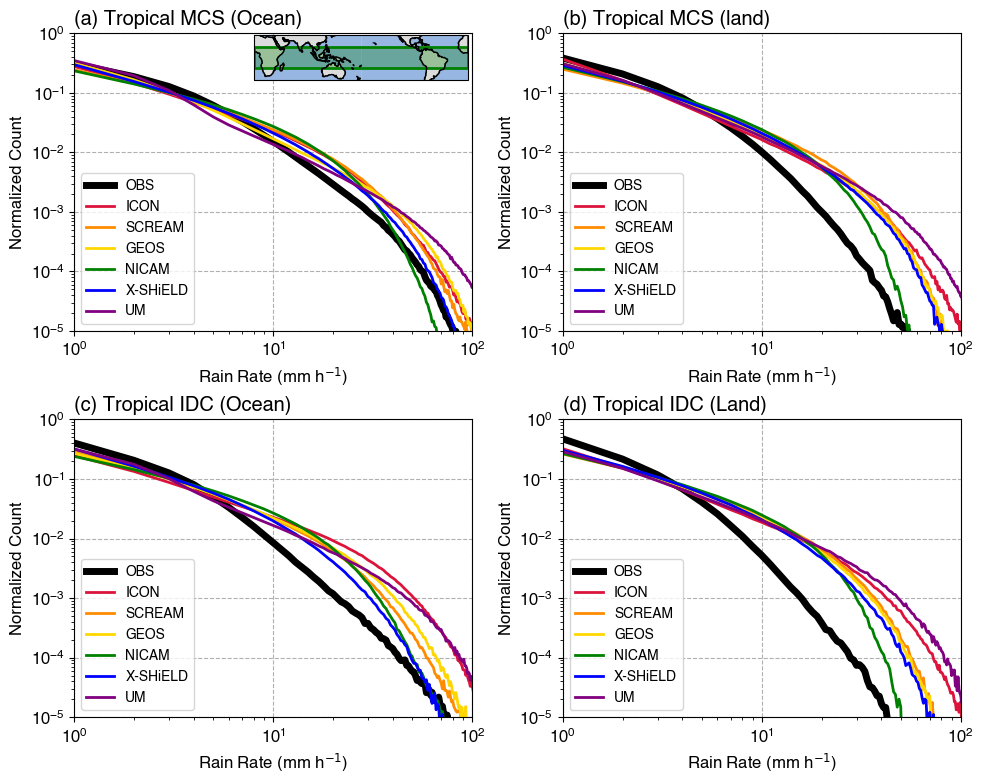

In [21]:
bins = rrbins
data_arr = [
    [norm_mcs_o, norm_mcs_l,], 
    [norm_idc_o, norm_idc_l,],
]
titles = [
    ['(a) Tropical MCS (Ocean)', '(b) Tropical MCS (land)', ],
    ['(c) Tropical IDC (Ocean)', '(d) Tropical IDC (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', 'Normalized Count'],
    ['Normalized Count', 'Normalized Count'],
]
xscale = 'log'
yscale = 'log'
xlims = [1, 100]
ylims = [
    [[1e-5,1], [1e-5,1]],
    [[1e-5,1], [1e-5,1]],
]
inset_param = {'width':'55%', 'height':'15%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_pdf_mcs_idc_{region}.png'
fig = plot_pdf_mxn(2, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims,
                   legend_fontsize=10, legend_loc='best', figsize=[10,8])

<ipython-input-18-3596e831e6d4>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


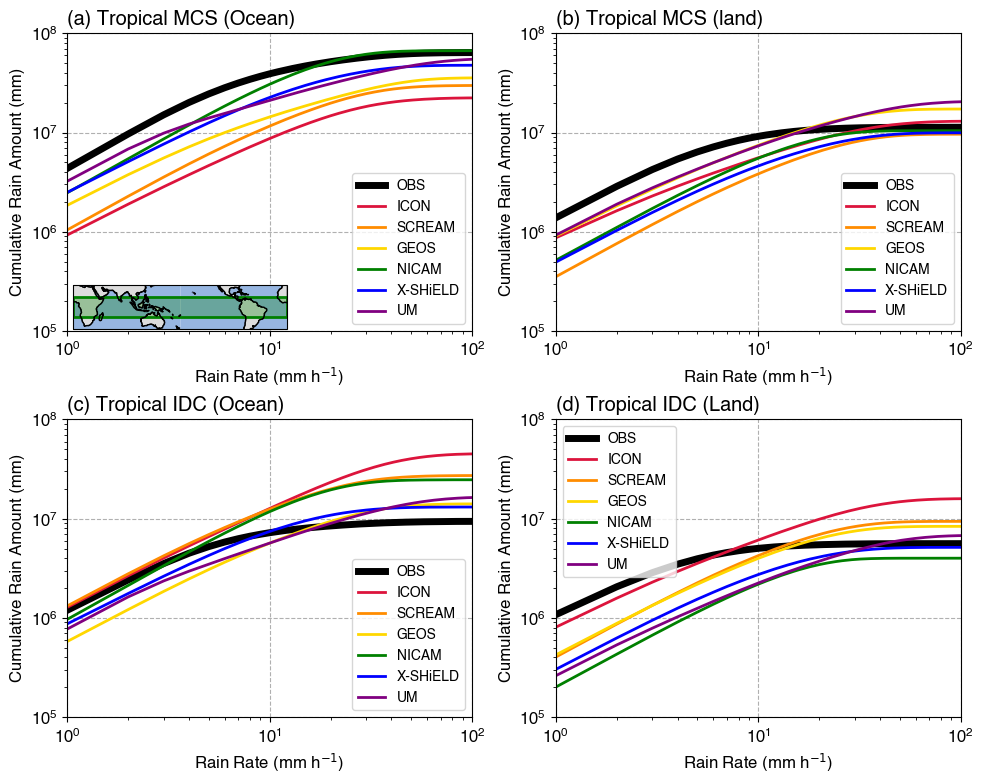

In [22]:
bins = rrbins
data_arr = [
    [mcsamt_cumhist_o, mcsamt_cumhist_l,], 
    [idcamt_cumhist_o, idcamt_cumhist_l,],
]
titles = [
    ['(a) Tropical MCS (Ocean)', '(b) Tropical MCS (land)', ],
    ['(c) Tropical IDC (Ocean)', '(d) Tropical IDC (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Cumulative Rain Amount (mm)', 'Cumulative Rain Amount (mm)'],
    ['Cumulative Rain Amount (mm)', 'Cumulative Rain Amount (mm)'],
]
xscale = 'log'
yscale = 'log'
xlims = [1, 100]
ylims = [
    [[1e5,1e8], [1e5,1e8]],
    [[1e5,1e8], [1e5,1e8]],
]
inset_param = {'width':'55%', 'height':'15%', 'loc':'lower left', 'borderpad':0.1}
figname = f'{figdir}rainamount_cumhist_mcs_idc_{region}.png'
fig = plot_pdf_mxn(2, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims,
                   legend_fontsize=10, legend_loc='best', figsize=[10,8])